In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
 # 1. Load Data
 df = pd.read_csv("train_revised.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32782 entries, 0 to 32781
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          32782 non-null  int64 
 1   seat_number      32782 non-null  object
 2   payment_method   32782 non-null  object
 3   payment_receipt  32782 non-null  object
 4   travel_date      32782 non-null  object
 5   travel_time      32782 non-null  object
 6   travel_from      32782 non-null  object
 7   travel_to        32782 non-null  object
 8   car_type         32782 non-null  object
 9   max_capacity     32782 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 2.5+ MB


In [8]:
df.shape

(32782, 10)

In [9]:
df.describe()

,ride_id,max_capacity
count,32782.000000,32782.000000
mean,8830.949057,31.213654
std,1522.500163,18.961488
min,1442.000000,11.000000
25%,7581.000000,11.000000
50%,8776.000000,49.000000
75%,10124.750000,49.000000
max,20113.000000,49.000000


In [10]:
df.isna().sum()

,0
ride_id,0
seat_number,0
payment_method,0
payment_receipt,0
travel_date,0
travel_time,0
travel_from,0
travel_to,0
car_type,0
max_capacity,0


In [11]:
df[["ride_id","seat_number"]].duplicated().sum()

np.int64(106)

In [12]:
# Show all duplicated rows based on ride_id and seat_number
duplicated_rows = df.loc[df[["ride_id", "seat_number"]].duplicated(), :]
print(duplicated_rows)


       ride_id seat_number payment_method payment_receipt travel_date  \
284       5778         17A          Mpesa      FWLBIYKARK    27-11-17   
1154      6398          10          Mpesa      6DJOWJGRTZ    01-12-17   
2253      6636         20A          Mpesa      9ETCE7PVQK    05-12-17   
2255      6636         18A          Mpesa      LZHIJXAWX1    05-12-17   
2422      6672           2          Mpesa      LHLKQUL2YZ    06-12-17   
...        ...         ...            ...             ...         ...   
32565    11270         22B          Mpesa      KAP8P6ZWN1    27-02-18   
32566    11270         21B          Mpesa      TNQR7F2LON    27-02-18   
32572    11270         23A          Mpesa      FOBJRIMM5A    27-02-18   
32576    11270         24A          Mpesa      L0YK9X9BLS    27-02-18   
32628    11270         16B          Mpesa      7U3UBIQVNO    27-02-18   

      travel_time travel_from travel_to car_type  max_capacity  
284          7:12      Migori   Nairobi      Bus          

In [13]:
# ===== 2. Data Cleaning =====
# Remove duplicates
df = df.drop_duplicates(subset=['ride_id', 'seat_number'])

In [14]:
df.shape

(32676, 10)

In [15]:
# Convert travel_date to datetime
df['travel_date'] = pd.to_datetime(df['travel_date'], format='%d-%m-%y', errors='coerce')

In [16]:
# Aggregate seats sold per ride
seats_per_ride = df.groupby(
    ['ride_id', 'travel_date', 'travel_time', 'travel_from', 'travel_to', 'car_type', 'max_capacity']
).size().reset_index(name='seats_sold')

In [17]:
# Cap seats_sold at max_capacity (just in case)
seats_per_ride['seats_sold'] = np.where(
    seats_per_ride['seats_sold'] > seats_per_ride['max_capacity'],
    seats_per_ride['max_capacity'],
    seats_per_ride['seats_sold']
)


In [18]:
print(seats_per_ride['seats_sold'])

0        1
1        1
2        1
3        5
4       30
        ..
4182     1
4183     1
4184    13
4185    11
4186     9
Name: seats_sold, Length: 4187, dtype: int64


In [19]:
# Add is_peak_demand feature (above 75th percentile)
Q3 = seats_per_ride['seats_sold'].quantile(0.75)
IQR = Q3 - seats_per_ride['seats_sold'].quantile(0.25)
upper_bound = Q3 + 1.5 * IQR
seats_per_ride['is_peak_demand'] = (seats_per_ride['seats_sold'] > upper_bound).astype(int)

In [20]:
print(f"✅ Data cleaned! Total rides: {seats_per_ride.shape[0]}")

✅ Data cleaned! Total rides: 4187


In [21]:
# ===== 3. Feature Engineering =====
seats_per_ride['day_of_week'] = seats_per_ride['travel_date'].dt.day_name()
seats_per_ride['month'] = seats_per_ride['travel_date'].dt.month
seats_per_ride['hour'] = pd.to_datetime(seats_per_ride['travel_time'], errors='coerce').dt.hour

/tmp/ipython-input-561317627.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seats_per_ride['hour'] = pd.to_datetime(seats_per_ride['travel_time'], errors='coerce').dt.hour


In [22]:
# Drop unnecessary columns
data = seats_per_ride.drop(['ride_id', 'travel_date', 'travel_time', 'travel_to'], axis=1)


In [23]:
# One-hot encode categorical columns
data = pd.get_dummies(data, columns=['travel_from', 'car_type', 'day_of_week'], drop_first=True)

travel_from
Kendu Bay        9190
Sori             9597
Oyugis          13288
Keumbu         121602
Awendo         708020
Kehancha       730331
Nyachenge      835467
Sirare         892157
Homa Bay      1852746
Keroka        1992087
Migori        2231122
Kijauri       2630284
Rongo         3950577
Kisii        20370882
Name: ride_id, dtype: int64


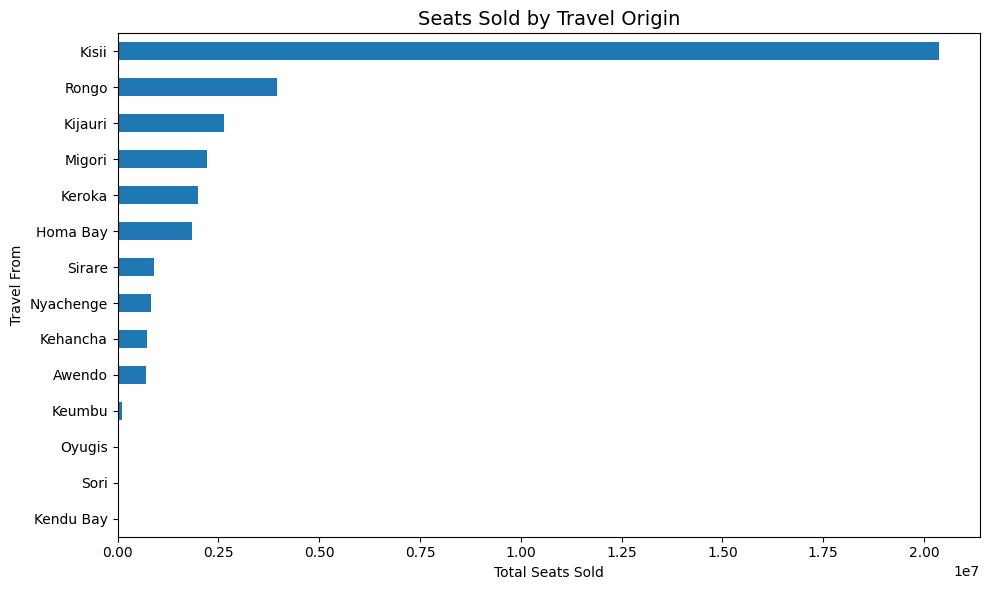

In [24]:
# Group by travel_from and sum seats_sold

seats_by_travel = seats_per_ride.groupby('travel_from')['ride_id'].sum().sort_values()
print(seats_by_travel)
# Plot
plt.figure(figsize=(10, 6))
seats_by_travel.plot(kind='barh')  # horizontal bar plot for readability

plt.title("Seats Sold by Travel Origin", fontsize=14)
plt.xlabel("Total Seats Sold")
plt.ylabel("Travel From")
plt.tight_layout()
plt.show()


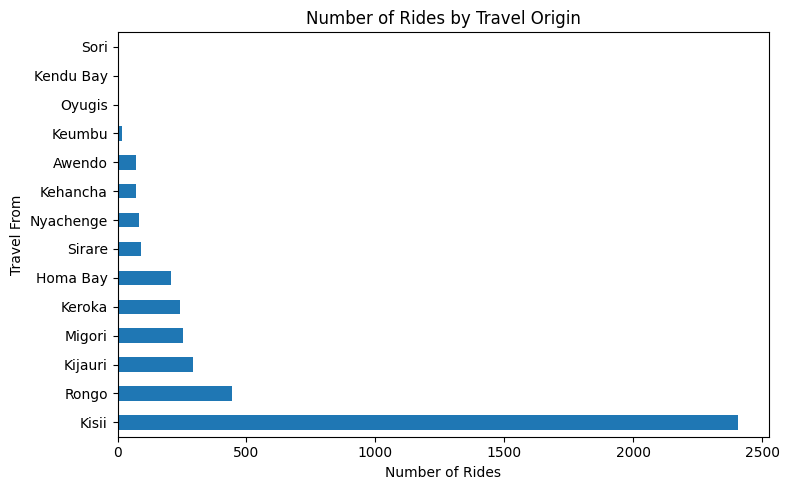

In [25]:
rides_count = seats_per_ride['travel_from'].value_counts()

plt.figure(figsize=(8, 5))
rides_count.plot(kind='barh')
plt.title("Number of Rides by Travel Origin")
plt.xlabel("Number of Rides")
plt.ylabel("Travel From")
plt.tight_layout()
plt.show()

hour
5      378
6      311
7     2056
8      418
9      382
10     441
11      61
19     140
Name: count, dtype: int64


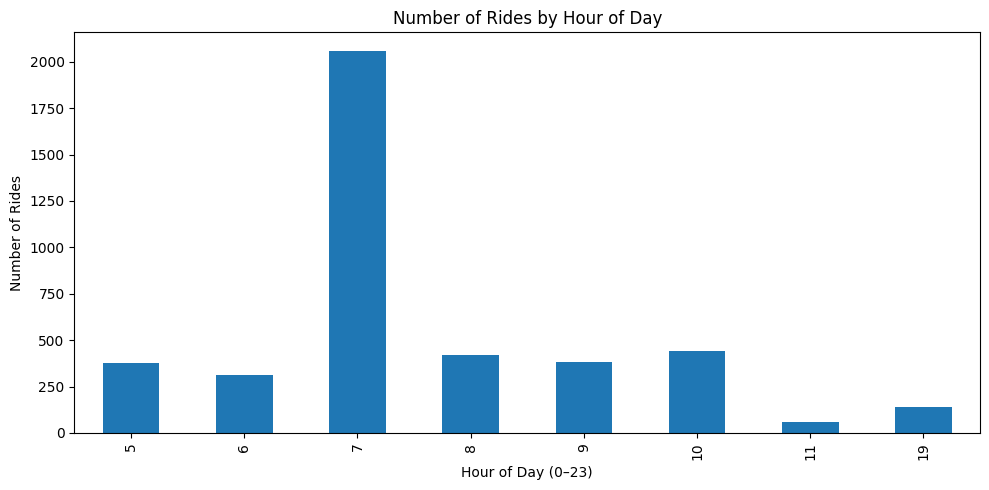

In [26]:
rides_by_hour = seats_per_ride['hour'].value_counts().sort_index()
print(rides_by_hour)
plt.figure(figsize=(10, 5))
rides_by_hour.plot(kind='bar')
plt.title("Number of Rides by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Rides")
plt.tight_layout()
plt.show()


day_of_week
Friday       739
Thursday     665
Wednesday    639
Sunday       637
Monday       565
Tuesday      562
Saturday     380
Name: count, dtype: int64


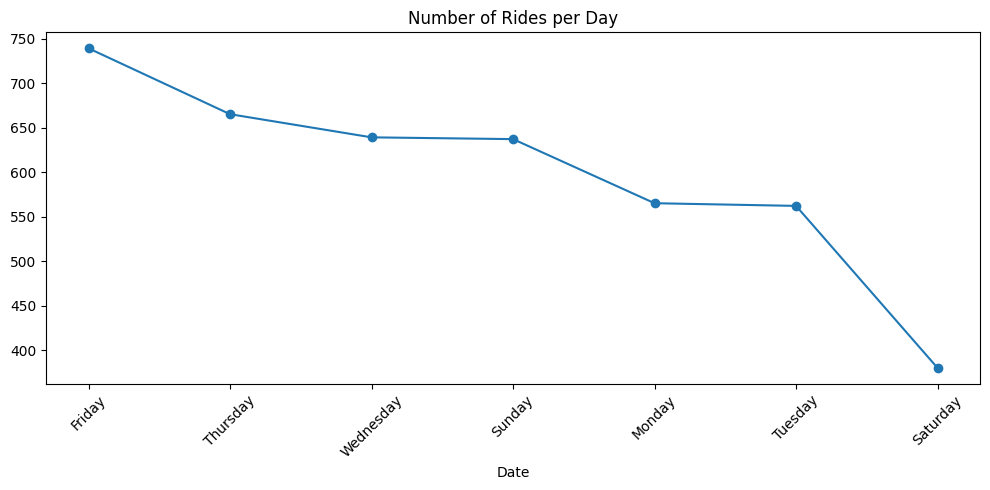

In [27]:
rides_by_day = seats_per_ride['day_of_week'].value_counts()
print(rides_by_day)

plt.figure(figsize=(10, 5))
rides_by_day.plot(kind='line', marker='o')  # You can also use kind='bar'
plt.title("Number of Rides per Day")
plt.xlabel("Date")
plt.xticks(rotation=45)  # rotate dates so they don't overlap
plt.tight_layout()
plt.show()


In [28]:
rides_by_month = seats_per_ride['month'].value_counts().sort_index()
print(rides_by_month)


month
1      952
2     1494
3      582
4      134
10       1
11      34
12     990
Name: count, dtype: int64


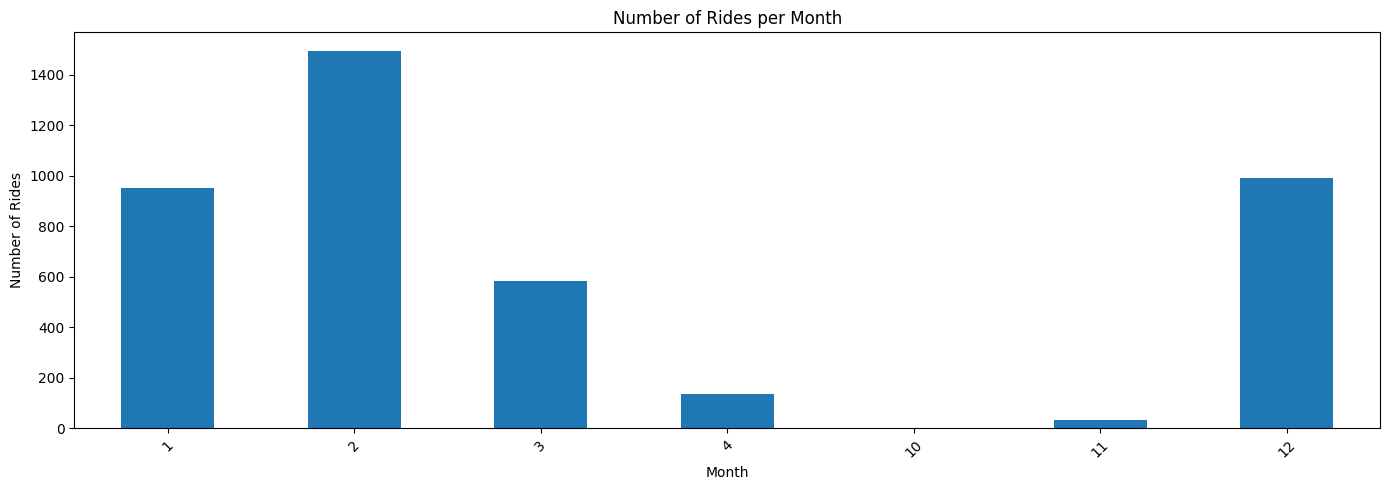

In [29]:
plt.figure(figsize=(14,5))
rides_by_month.plot(kind='bar')
plt.title("Number of Rides per Month")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)  # rotate month labels
plt.tight_layout()
plt.show()

In [30]:
# Split features and target
X = data.drop('seats_sold', axis=1)
y = data['seats_sold']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (3349, 24), Test shape: (838, 24)


In [32]:
# ===== 4. Train Random Forest (Tuned Parameters) =====

best_rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

In [33]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [34]:
# ===== 5. Evaluate Model =====
preds = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds,)
r2 = r2_score(y_test, preds)

print("\n=== Final Model Performance ===")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")



=== Final Model Performance ===
MAE : 3.2146
RMSE: 19.1199
R²  : 0.6925


In [35]:
# ===== 6. Feature Importances =====
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\n=== Top 10 Important Features ===")
print(importances.head(10))


=== Top 10 Important Features ===
is_peak_demand           0.727898
hour                     0.045486
month                    0.038089
travel_from_Kijauri      0.033189
travel_from_Keroka       0.023905
travel_from_Rongo        0.017826
travel_from_Nyachenge    0.015195
travel_from_Sirare       0.014314
day_of_week_Saturday     0.012786
travel_from_Kisii        0.010682
dtype: float64


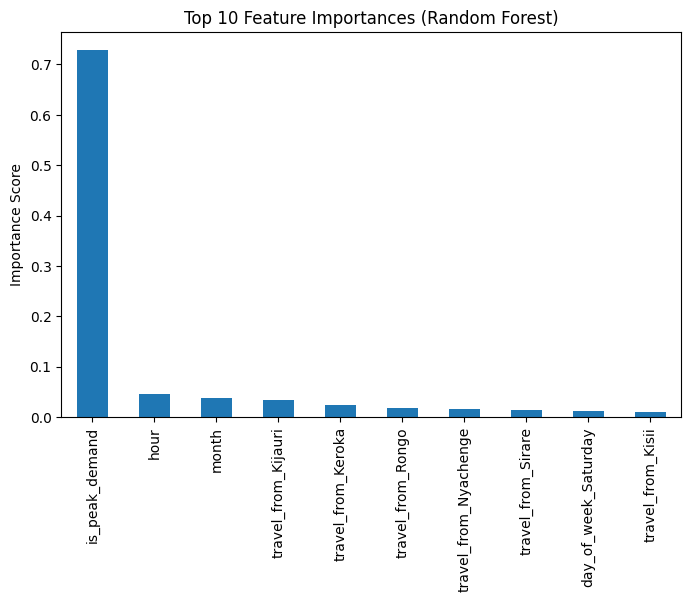

In [36]:
plt.figure(figsize=(8, 5))
importances.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

In [37]:
# Predict seats sold using the trained model
y_pred = best_rf.predict(X_test)

print("First 10 Predicted Seats Sold:")
print(y_pred[:10])


First 10 Predicted Seats Sold:
[ 1.44761644  3.9780358   6.06953852  2.22107184  6.32116145  1.78160215
  8.19828634  9.30235524 11.39878382  1.64887929]


In [38]:
import pandas as pd

comparison = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

print(comparison.head(10))


      Actual  Predicted
1029       2   1.447616
4065       1   3.978036
869       10   6.069539
96         1   2.221072
803        8   6.321161
109        2   1.781602
196        1   8.198286
4086      23   9.302355
1820       8  11.398784
746        1   1.648879


In [39]:
def predict_seats(travel_from, date, time, peak_demand=False):
    """
    Predict seats sold for a given ride.
    time: str in format "HH:MM"
    peak_demand: bool (True if peak demand, else False)
    """
    from datetime import datetime

    # Convert date/time
    dt = datetime.strptime(f"{date} {time}", "%Y-%m-%d %H:%M")
    month = dt.month
    day_of_week = dt.strftime("%A")
    hour = dt.hour

    # Build a single-row DataFrame with ride info
    ride = pd.DataFrame([{
        "travel_from": travel_from,
        "month": month,
        "hour": hour,
        "is_peak_demand": int(peak_demand),
        # add dummy column for day of week
        f"day_of_week_{day_of_week}": 1
    }])

    # One-hot encode and align with training columns
    ride = pd.get_dummies(ride)
    ride = ride.reindex(columns=X_train.columns, fill_value=0)

    # Predict using trained model
    prediction = best_rf.predict(ride)
    return round(prediction[0], 2)


In [40]:
result = predict_seats(
    travel_from="Kijauri",
    date="2025-09-20",
    time="14:00",
    peak_demand=True
)

print(f"Predicted Seats Sold: {result}")


Predicted Seats Sold: 31.03
